<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D1%83%D0%B4%D0%B0%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE%D0%B2%D1%82%D0%BE%D1%80%D1%8F%D1%8E%D1%89%D0%B8%D1%85%D1%81%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B8%D0%B7_%D0%BD%D0%B0%D0%B1%D0%BE%D1%80%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%B4%D0%BB%D1%8F_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Обнаружение и удаление повторяющихся изображений из набора данных для глубокого обучения

# Detect and remove duplicate images from the deep learning dataset

В этом уроке вы узнаете, как обнаруживать и удалять повторяющиеся изображения из датасета для глубокого обучения.

In this tutorial, you will learn how to detect and remove duplicate images from a deep learning dataset.



Мы реализуем наш детектор дубликатов изображений, используя хеширование изображений.

We will implement our duplicate image detector using image hashing.



Хеширование изображений или перцептивное хеширование - это:

Image hashing or perceptual hashing is:

1. Изучение содержимого изображения. Exploring the content of the image
2. Создание хеш-значения, которое однозначно идентифицирует входное изображение на основе визуального содержимого изображения. Creation of a hash value that uniquely identifies the input image based on the visual content of the image.



Наш алгоритм вычисляет хэш изображения на основе его внешнего вида.


Our algorithm calculates the hash of the image based on its appearance.

В качестве датасета возьмем целую папку изображений с котами, где 100 изображений имеют дубликаты.



As a dataset, let's take a whole folder of images with cats, where 100 images have duplicates.

### Загрузка файлов
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_30.detect_duplicate_dataset.zip
!unzip -qq Lesson_30.detect_duplicate_dataset.zip
%cd /content/Lesson_30.detect_duplicate_dataset/

--2022-02-21 05:55:38--  http://dataudt.ru/datasets/cv/Lesson_30.detect_duplicate_dataset.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21195674 (20M) [application/zip]
Saving to: ‘Lesson_30.detect_duplicate_dataset.zip’

Lesson_30.detect_du 100%[===================>]  20.21M  37.3MB/s    in 0.5s    

2022-02-21 05:55:38 (37.3 MB/s) - ‘Lesson_30.detect_duplicate_dataset.zip’ saved [21195674/21195674]

/content/Lesson_30.detect_duplicate_dataset


### Импорт библиотек
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Реализация нашего детектора дубликатов изображений
### Implementing our image duplicate detector

In [4]:
def dhash(image, hashSize=8):
    # преобразовываем изображение в оттенки серого и изменяем его размер,
	# добавляем один столбец (ширину), чтобы мы могли вычислить горизонтальный градиент
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

    # вычисляем (относительный) горизонтальный градиент между соседними
	# столбцами пикселей
	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

    # конвертируем разность в хэш и возвращаем его
	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [5]:

# явно укажем аргументы необходимые для работы
# dataset - путь к входному набору данных
# remove - следует ли удалять дубликаты (т.е. сухой прогон).

# explicitly specify the arguments needed to work
# dataset - path to input dataset
# remove - whether or not duplicates should be removed (i.e., dry run)
args = {
	"dataset": "dataset",
	"remove": -1
}

In [6]:
# получаем пути ко всем изображениям в нашем датасете,
# затем инициализируем наш словарь хешей
# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
imagePaths = list(paths.list_images(args["dataset"]))
hashes = {}

# перебираем пути к изображениям
# loop over our image paths
for imagePath in imagePaths:
    # загружаем входное изображение и вычисляем хэш
	# load the input image and compute the hash
	image = cv2.imread(imagePath)
	h = dhash(image)

    # берем все пути к изображениям с этим хешем, добавить текущее изображение
	# путь к нему и сохранить список обратно в словарь хешей
	# grab all image paths with that hash, add the current image
	# path to it, and store the list back in the hashes dictionary
	p = hashes.get(h, [])
	p.append(imagePath)
	hashes[h] = p

[INFO] computing image hashes...


[INFO] hash: 8739932127790133039


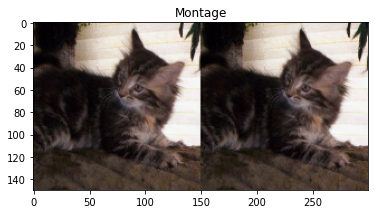

[INFO] hash: 9630329821137119939


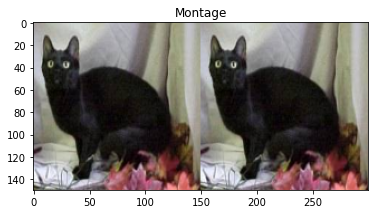

[INFO] hash: 7409785146405247827


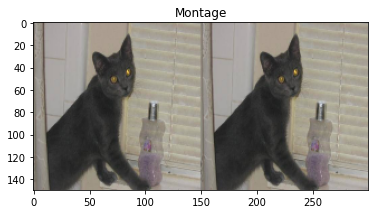

[INFO] hash: 8244517692003378756


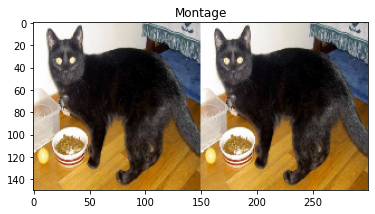

[INFO] hash: 13882051656005498082


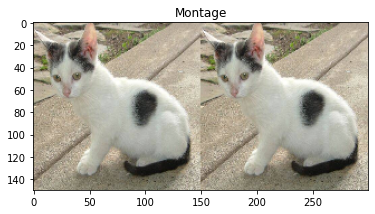

[INFO] hash: 4158554269578007991


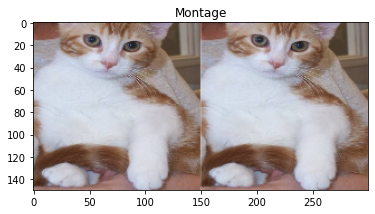

[INFO] hash: 12197111995808444420


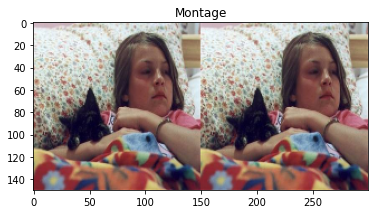

[INFO] hash: 5120086327226466629


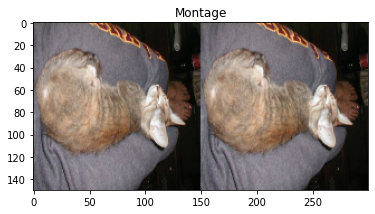

[INFO] hash: 691488241985414510


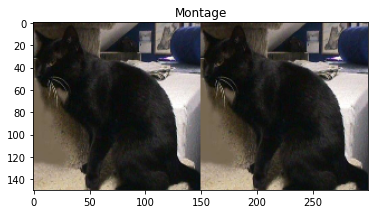

[INFO] hash: 4417410659647856026


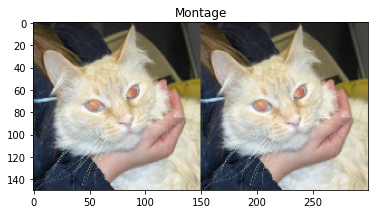

[INFO] hash: 4837893111755908867


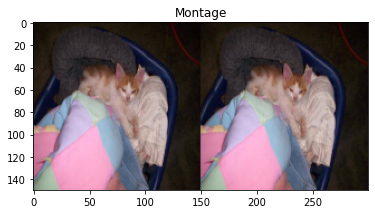

[INFO] hash: 13049755042518910791


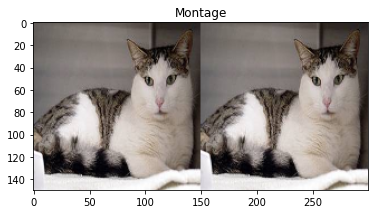

[INFO] hash: 1710328091292456727


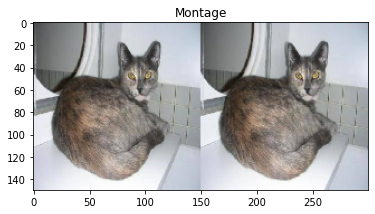

[INFO] hash: 5325057371994460007


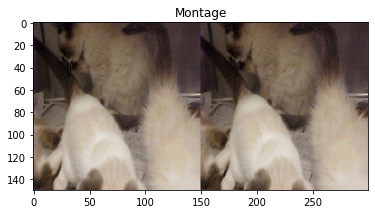

[INFO] hash: 16270336572469163588


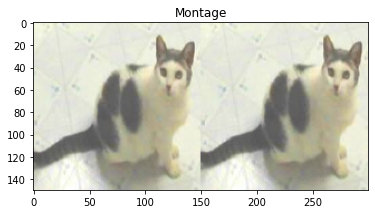

[INFO] hash: 5212008822325506162


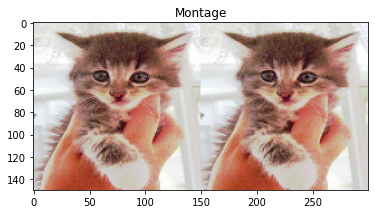

[INFO] hash: 6788918070329287757


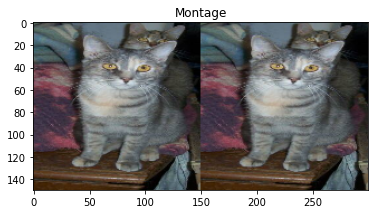

In [ ]:
# перебираем хэши изображений
# loop over the image hashes
for (h, hashedPaths) in hashes.items():
    # проверяем, есть ли более одного изображения с одинаковым хешем
	# check to see if there is more than one image with the same hash
	if len(hashedPaths) > 1:
        # проверяем, не пробный ли это прогон
		# check to see if this is a dry run
		if args["remove"] <= 0:
            # создаем коллаж для хранения всех изображений с одинаковыми хешами
			# initialize a montage to store all images with the same
			# hash
			montage = None

            # перебираем все пути к изображениям с одним и тем же хешем
			# loop over all image paths with the same hash
			for p in hashedPaths:
                # загружаем входное изображение и изменяем его размер до фиксированной ширины
				# и высоты
				# load the input image and resize it to a fixed width
				# and heightG
				image = cv2.imread(p)
				image = cv2.resize(image, (150, 150))

                # если коллажа нет, создаем его
				# if our montage is None, initialize it
				if montage is None:
					montage = image

                # в противном случае совмещаем изображения горизонтально
				# otherwise, horizontally stack the images
				else:
					montage = np.hstack([montage, image])

            # показываем коллаж для хеша
			# show the montage for the hash
			print("[INFO] hash: {}".format(h))
			plt_imshow("Montage", montage)

        # в противном случае, удаляем повторяющиеся изображения
        # otherwise, we'll be removing the duplicate images
		else:
            # перебираем все пути к изображениям с одним и тем же хешем * кроме *
			# первого изображения в списке (поскольку мы хотим сохранить
			# одно и только одно из повторяющихся изображений)
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
			for p in hashedPaths[1:]:
				os.remove(p)